In [284]:
import ee
import geemap
import sys
import os
import pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(),os.pardir)))
from src import eetools as eet
import matplotlib.pyplot as plt

In [241]:
try: 
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [310]:
coordenadas = "-48.53801472648439,-22.503806214013736,-48.270222978437516,-22.7281869567509"
x1, y1, x2, y2 = coordenadas.split(",")

datas = "2014-08-01,2014-12-01"
inicio, fim = datas.split(",")
escala = 30
dummy_value = 99999

geom = ee.Geometry.Polygon([[[float(x1),float(y2)],
                             [float(x2),float(y2)],
                             [float(x2),float(y1)],
                             [float(x1),float(y1)],
                             [float(x1),float(y2)]]])

latitude_central = (float(x1)+float(x2))/2
longitude_central = (float(y1)+float(y2))/2

collec = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')\
    .filterBounds(geom)\
    .filterDate(inicio,fim)\
    .filterMetadata('CLOUD_COVER','less_than',30)\
    .map(eet.ndvi)

In [311]:
ndvi_collec = ee.ImageCollection(collec\
    .select('ndvi')\
    .toList(999)\
    .map(
        lambda img: ee.Image(img)\
            .set(
                'system:index',
                ee.String(ee.Image(img).get('SENSING_TIME')).replace('-|:|\\.','_','g')
            )
        ))\
    .sort('system:index')\
    .toBands()

ndvi_collec_bands = ndvi_collec\
    .bandNames()\
    .getInfo()

In [312]:
blended = ee.Image(99999).blend(ndvi_collec)
blended

In [313]:
df = eet.extrair_lonlat(blended, geom, ndvi_collec_bands, escala)
df

,2014_08_01T13_16_17_6581530Z_ndvi,2014_08_01T13_16_41_6000220Z_ndvi,2014_08_17T13_16_23_4096060Z_ndvi,2014_09_02T13_16_25_7726310Z_ndvi,2014_09_02T13_16_49_7102640Z_ndvi,2014_09_11T13_10_41_1118500Z_ndvi,2014_09_18T13_16_26_7334180Z_ndvi,2014_09_18T13_16_50_6752870Z_ndvi,2014_10_04T13_16_30_3092830Z_ndvi,2014_10_04T13_16_54_2553880Z_ndvi,2014_10_13T13_10_45_7041390Z_ndvi,2014_10_29T13_10_41_8501550Z_ndvi,2014_11_05T13_16_32_4161130Z_ndvi,latitude,longitude
0,99999.0,99999.0,99999.0,99999.0,99999.0,0.328715,99999.0,99999.0,99999.0,99999.0,0.482913,0.465691,99999.0,-22.728169,-48.537927
1,99999.0,99999.0,99999.0,99999.0,99999.0,0.705186,99999.0,99999.0,99999.0,99999.0,0.687115,0.750785,99999.0,-22.728169,-48.537627
2,99999.0,99999.0,99999.0,99999.0,99999.0,0.747272,99999.0,99999.0,99999.0,99999.0,0.724499,0.777710,99999.0,-22.728169,-48.537327
3,99999.0,99999.0,99999.0,99999.0,99999.0,0.709579,99999.0,99999.0,99999.0,99999.0,0.729393,0.819333,99999.0,-22.728169,-48.537027
4,99999.0,99999.0,99999.0,99999.0,99999.0,0.737570,99999.0,99999.0,99999.0,99999.0,0.742866,0.824793,99999.0,-22.728169,-48.536727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667211,99999.0,99999.0,99999.0,99999.0,99999.0,0.455296,99999.0,99999.0,99999.0,99999.0,0.238938,0.299978,99999.0,-22.503906,-48.271634
667212,99999.0,99999.0,99999.0,99999.0,99999.0,0.447883,99999.0,99999.0,99999.0,99999.0,0.242439,0.317909,99999.0,-22.503906,-48.271334
667213,99999.0,99999.0,99999.0,99999.0,99999.0,0.458235,99999.0,99999.0,99999.0,99999.0,0.240911,0.320276,99999.0,-22.503906,-48.271033
667214,99999.0,99999.0,99999.0,99999.0,99999.0,0.430154,99999.0,99999.0,99999.0,99999.0,0.241740,0.319300,99999.0,-22.503906,-48.270733


In [314]:
def correct_dummies(df, dummy_value):
    df = df.where(df != dummy_value)

    coord = df[['latitude','longitude']]
    images = df.drop(['latitude','longitude'],axis=1)
    images.iloc[:,0] = images.iloc[:,0].fillna(images.mean(axis=1))

    return images.fillna(method='ffill',axis=1).join(coord)

df_corr = correct_dummies(df,dummy_value)
df_corr


,2014_08_01T13_16_17_6581530Z_ndvi,2014_08_01T13_16_41_6000220Z_ndvi,2014_08_17T13_16_23_4096060Z_ndvi,2014_09_02T13_16_25_7726310Z_ndvi,2014_09_02T13_16_49_7102640Z_ndvi,2014_09_11T13_10_41_1118500Z_ndvi,2014_09_18T13_16_26_7334180Z_ndvi,2014_09_18T13_16_50_6752870Z_ndvi,2014_10_04T13_16_30_3092830Z_ndvi,2014_10_04T13_16_54_2553880Z_ndvi,2014_10_13T13_10_45_7041390Z_ndvi,2014_10_29T13_10_41_8501550Z_ndvi,2014_11_05T13_16_32_4161130Z_ndvi,latitude,longitude
0,0.425773,0.425773,0.425773,0.425773,0.425773,0.328715,0.328715,0.328715,0.328715,0.328715,0.482913,0.465691,0.465691,-22.728169,-48.537927
1,0.714362,0.714362,0.714362,0.714362,0.714362,0.705186,0.705186,0.705186,0.705186,0.705186,0.687115,0.750785,0.750785,-22.728169,-48.537627
2,0.749827,0.749827,0.749827,0.749827,0.749827,0.747272,0.747272,0.747272,0.747272,0.747272,0.724499,0.777710,0.777710,-22.728169,-48.537327
3,0.752769,0.752769,0.752769,0.752769,0.752769,0.709579,0.709579,0.709579,0.709579,0.709579,0.729393,0.819333,0.819333,-22.728169,-48.537027
4,0.768410,0.768410,0.768410,0.768410,0.768410,0.737570,0.737570,0.737570,0.737570,0.737570,0.742866,0.824793,0.824793,-22.728169,-48.536727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667211,0.331404,0.331404,0.331404,0.331404,0.331404,0.455296,0.455296,0.455296,0.455296,0.455296,0.238938,0.299978,0.299978,-22.503906,-48.271634
667212,0.336077,0.336077,0.336077,0.336077,0.336077,0.447883,0.447883,0.447883,0.447883,0.447883,0.242439,0.317909,0.317909,-22.503906,-48.271334
667213,0.339807,0.339807,0.339807,0.339807,0.339807,0.458235,0.458235,0.458235,0.458235,0.458235,0.240911,0.320276,0.320276,-22.503906,-48.271033
667214,0.330398,0.330398,0.330398,0.330398,0.330398,0.430154,0.430154,0.430154,0.430154,0.430154,0.241740,0.319300,0.319300,-22.503906,-48.270733


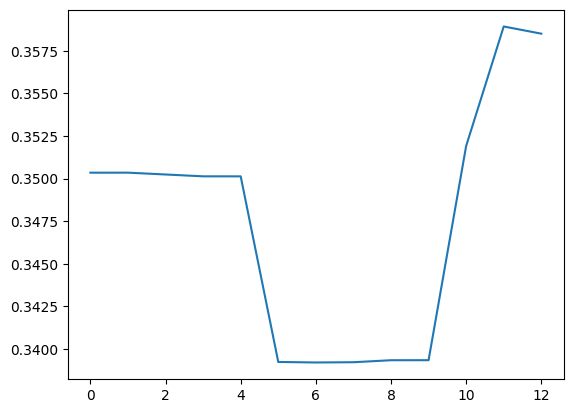

In [315]:
y = df_corr.drop(['latitude','longitude'],axis=1).mean()
x = pd.Series(range(0,len(y)))

plt.plot(x,y)

In [344]:
image = df_corr.iloc[:,[0,5,10,13,14]]
image

,2014_08_01T13_16_17_6581530Z_ndvi,2014_09_11T13_10_41_1118500Z_ndvi,2014_10_13T13_10_45_7041390Z_ndvi,latitude,longitude
0,0.425773,0.328715,0.482913,-22.728169,-48.537927
1,0.714362,0.705186,0.687115,-22.728169,-48.537627
2,0.749827,0.747272,0.724499,-22.728169,-48.537327
3,0.752769,0.709579,0.729393,-22.728169,-48.537027
4,0.768410,0.737570,0.742866,-22.728169,-48.536727
...,...,...,...,...,...
667211,0.331404,0.455296,0.238938,-22.503906,-48.271634
667212,0.336077,0.447883,0.242439,-22.503906,-48.271334
667213,0.339807,0.458235,0.240911,-22.503906,-48.271033
667214,0.330398,0.430154,0.241740,-22.503906,-48.270733


In [345]:
from src import saveModule

In [347]:
saveModule.save_tiff_from_df(
    df=image,
    bands=list(image.drop(['latitude','longitude'],axis=1).columns),
    dummy=dummy_value,
    path_out="imagem.tif",
    coordSystem="EPSG:4326"
)

True

In [348]:
from osgeo import gdal
filepath = r'imagem.tif'
raster = gdal.Open(filepath)

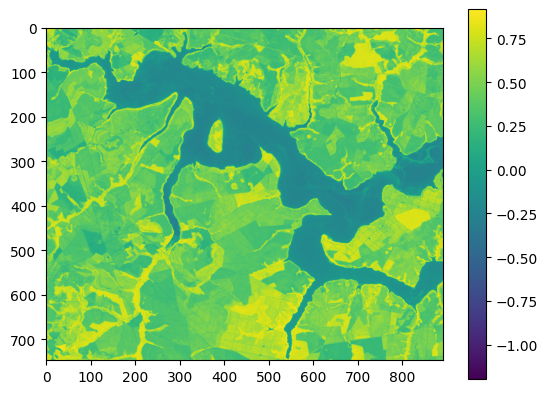

In [355]:
array = raster.GetRasterBand(1).ReadAsArray()
plt.imshow(array)
plt.colorbar()

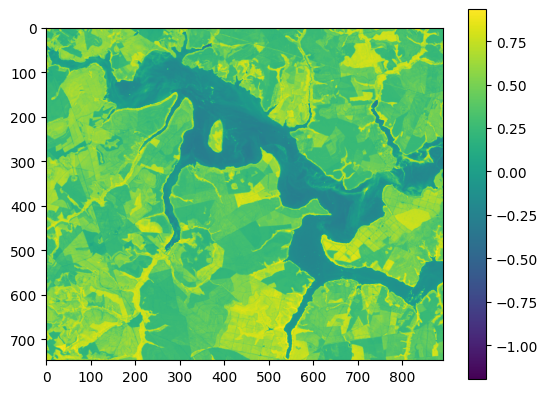

In [356]:
array = raster.GetRasterBand(2).ReadAsArray()
plt.imshow(array)
plt.colorbar()